In [1]:
%pip install -qe "data/SpLiCE/"

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -q open_clip_torch

Note: you may need to restart the kernel to use updated packages.


In [1]:
from pathlib import Path
import pickle

import splice
import open_clip
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from PIL import Image
from rastervision.core.box import Box
from rastervision.core.data import RasterioSource
from matplotlib import pyplot as plt
import albumentations as A
DEVICE = 'cuda'

In [2]:
model_name = 'ViT-L-14'
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

print('#params: ', f'{sum(p.numel() for p in model.parameters()):,}')

#params:  427,616,513


In [3]:
ckpt_path = 'data/SkyCLIP_ViT_L14_top50pct/epoch_20.pt'
ckpt = torch.load(ckpt_path, map_location='cpu')['state_dict']
ckpt = {k[len('module.'):]:v for k, v in ckpt.items()}
message = model.load_state_dict(ckpt)
model = model.eval()
model = model.to(DEVICE)

In [4]:
vocabulary = splice.get_vocabulary('laion', 10_000) 

In [109]:
vocabulary = [
    'urban',
    'suburban',
    'agricultural',
    'sports',
    'stadium',
    'baseball',
    'basketball',
    'tennis',
    'football',
    'soccer',
    'tree',
    'trees',
    'house',
    'forest',
    'road',
    'street',
    'highway',
    'residential',
    'swimming pool',
    'parking lot',
    'fall foliage',
    'automobile',
    'airport',
    'harbor',
    'warehouse',
    'industrial',
    'field',
    'water',
    'river',
    'dockyard',
    'apartment',
    'building',
    'buildings',
]

In [110]:
dl = DataLoader(vocabulary, batch_size=32)

In [111]:
concept_embs = torch.zeros(len(vocabulary), 768)
with torch.inference_mode(), tqdm(dl, desc='Creating concept embeddings') as bar:
    i = 0
    for x in bar:
        x = tokenizer(x)
        x = x.to(DEVICE)
        emb = model.encode_text(x)
        concept_embs[i:i + len(x)] = emb.cpu()
        i += len(x)
concept_embs.shape

Creating concept embeddings: 100%|████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 38.15it/s]


torch.Size([33, 768])

In [112]:
concepts = torch.nn.functional.normalize(concept_embs, dim=1)
# concepts_mean = concepts.mean(dim=0)
# concepts = concepts - concepts_mean
# concepts = torch.nn.functional.normalize(concepts, dim=1)

---

In [8]:
img_embs = torch.load('data/skyscript_naip_MA_400_400.pt')
img_embs.shape

torch.Size([563379, 768])

In [9]:
img_mean = img_embs.mean(dim=0)

In [169]:
splicemodel = splice.SPLICE(img_mean, concepts, clip=model, device=DEVICE, return_weights=True, l1_penalty=1e-8, solver='skl')

In [11]:
rs = RasterioSource('data/m_3907506_ne_18_060_20191019.tif', channel_order=[0, 1, 2])

In [10]:
image = rs.get_chip(Box(0, 0, 800, 800).translate(3000, 1500))

In [178]:
image = rs.get_chip(Box(0, 0, 400, 400).translate(10200, 9500))

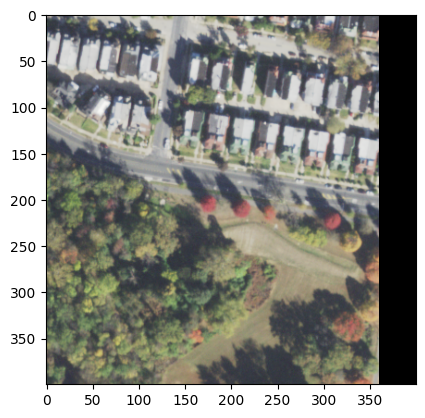

In [179]:
plt.imshow(image)
plt.show()

In [144]:
tf = A.Compose([
    A.Resize(224, 224),
    # A.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)),
])

In [180]:
with torch.inference_mode():
    x = tf(image=image)['image']
    x = x / 255.
    x = torch.from_numpy(x)
    x = x.permute(2, 0, 1).unsqueeze(0)
    x = x.to(device=DEVICE, dtype=torch.float32)
    sparse_weights = splicemodel.encode_image(x)

In [182]:
sparse_weights = sparse_weights.squeeze()

for weight_idx in torch.sort(sparse_weights, descending=True)[1]:
    print(f'{vocabulary[weight_idx]}: {sparse_weights[weight_idx]}')

street: 0.056621965020895004
suburban: 0.016721269115805626
urban: 0.0
agricultural: 0.0
sports: 0.0
stadium: 0.0
baseball: 0.0
basketball: 0.0
tennis: 0.0
football: 0.0
soccer: 0.0
tree: 0.0
trees: 0.0
house: 0.0
forest: 0.0
road: 0.0
highway: 0.0
residential: 0.0
swimming pool: 0.0
parking lot: 0.0
fall foliage: 0.0
automobile: 0.0
airport: 0.0
harbor: 0.0
warehouse: 0.0
industrial: 0.0
field: 0.0
water: 0.0
river: 0.0
dockyard: 0.0
apartment: 0.0
building: 0.0
buildings: 0.0


---

In [183]:
tf = A.Compose([
    A.Resize(224, 224),
    # A.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)),
])

In [184]:
with torch.inference_mode():
    x = tf(image=image)['image']
    x = x / 255.
    x = torch.from_numpy(x)
    x = x.permute(2, 0, 1).unsqueeze(0)
    x = x.to(device=DEVICE, dtype=torch.float32)
    img_emb = model.encode_image(x)
    img_emb = torch.nn.functional.normalize(img_emb, dim=1)

In [185]:
T = 0.01
with torch.inference_mode():
    out = (img_emb.to('cpu') @ concepts.T)
    out = (out / T).softmax(dim=1)
    out = out.numpy().squeeze()

In [186]:
weights = out
weights_sorted_inds = np.argsort(-weights)
for i in weights_sorted_inds[:30]:
    print(f'{vocabulary[i]}: {weights[i]}')

residential: 0.27214229106903076
suburban: 0.17601317167282104
urban: 0.0889190286397934
highway: 0.07877518236637115
agricultural: 0.04604153707623482
buildings: 0.04469091817736626
road: 0.04036740958690643
street: 0.03609295189380646
river: 0.024197900667786598
dockyard: 0.01722564361989498
field: 0.01682760752737522
trees: 0.016571523621678352
fall foliage: 0.016348402947187424
apartment: 0.01582001894712448
industrial: 0.014018701389431953
house: 0.013704461976885796
automobile: 0.011176170781254768
forest: 0.010963767766952515
parking lot: 0.010400918312370777
harbor: 0.009867998771369457
airport: 0.006843306589871645
building: 0.005303876008838415
warehouse: 0.004857918713241816
tree: 0.00433886656537652
water: 0.0034628536086529493
sports: 0.003259096061810851
soccer: 0.0030407968442887068
stadium: 0.003002162091434002
tennis: 0.002012707758694887
swimming pool: 0.001561274053528905


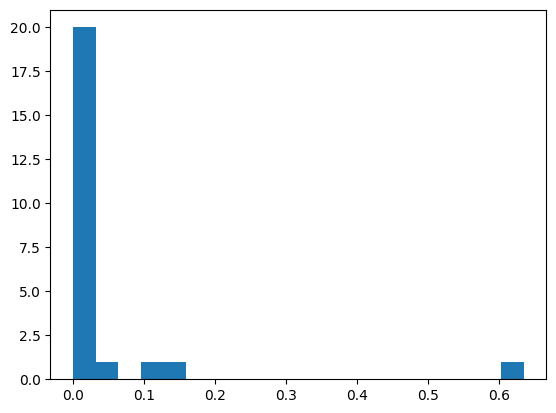

In [288]:
plt.hist(weights, bins=20)
plt.show()

In [68]:
np.where(weights_sorted_inds == 9697)

(array([311]),)

In [57]:
vocabulary.index('football')

9697

In [103]:
skyscript_metadata_root = Path('data/meta2')
skyscript_metadata_files = skyscript_metadata_root.glob('*.pickle')

In [104]:
tags = []
with tqdm(skyscript_metadata_files) as bar:
    for file in bar:
        with open(file, 'rb') as f:
            data = pickle.load(f)
            tags.append(data['center_tags'])
            tags.extend(data['surrounding_tags'])
len(tags)

680750it [00:10, 67685.29it/s]


3743482

In [106]:
all(isinstance(t, dict) for t in tags)

True

In [109]:
with tqdm(tags) as bar:
    num_tags_kv = sum((len(d) for d in bar))
num_tags_kv

100%|████████████████████████████████████████████████████████████████████| 3743482/3743482 [00:00<00:00, 6183513.65it/s]


7575750

In [110]:
tags_kv = [None] * num_tags_kv

In [151]:
i = 0
with tqdm(tags) as bar:
    for d in bar:
        for k, v in d.items():
            tags_kv[i] = k, v
            i += 1        

100%|████████████████████████████████████████████████████████████████████| 3743482/3743482 [00:01<00:00, 1992366.64it/s]


In [152]:
tags_kv[:10]

[('railway', 'abandoned'),
 ('service', 'siding'),
 ('tracks', '1'),
 ('abandoned', 'rail'),
 ('addr:street', 'Overland Trail'),
 ('addr:street', 'Overland Trail'),
 ('highway', 'residential'),
 ('barrier', 'wall'),
 ('amenity', 'prison'),
 ('surface', 'asphalt')]

In [153]:
tags_kv_filtered = tags_kv

In [166]:
tags_kv_filtered = [(k, v) for k, v in tags_kv_filtered if not bool(re.search(r'[:;_\d]', k)) and not bool(re.search(r'[:;_\d]', v))]

In [156]:
tags_kv_filtered = [(k, v) for k, v in tags_kv_filtered if 'note' not in k]

In [157]:
tags_kv_filtered = [(k, v) for k, v in tags_kv_filtered if 'description' not in k]

In [158]:
tags_kv_filtered = [(k, v) for k, v in tags_kv_filtered if 'inscription' not in k]

In [167]:
tags_kv_str = [f'{k} {v}' for k, v in tags_kv_filtered]

In [168]:
tags_set = set(tags_kv_str)
len(tags_set)

6989

In [169]:
for i, t in enumerate(tags_set):
    if i > 10:
        break
    print(t)

amenity museum
material coal
construction garage
denomination adventist
memorial memorial
building data center
building mobile
paved yes
industrial warehouse
road yes
tennis wall


In [170]:
vocabulary = list(tags_set)

In [47]:
!echo open_clip:{model_name}

open_clip:ViT-L-14


In [2]:
from PIL import Image

In [9]:
Image.fromarray(image).save('test.png')

In [49]:
!python data/SpLiCE/decompose_image.py -path test.png -out_path test.txt -l1_penalty 0.25 -model open_clip:ViT-B-32 --verbose

Concept Decomposition of test.png:
	cemetery	0.067
	proposed	0.0522
	campus	0.0415
	houses	0.0351
	suburb	0.035
	towns	0.0342
	overview	0.0301
	maps	0.0183
	aerial	0.0182
	course	0.0138
	site	0.0066
	neighbourhood	0.0065
	satellite	0.0037
	residential	0.0023
Decomposition L0 Norm: 	14.0
CLIP, SpLiCE Cosine Sim: 	0.5667
